In [1]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym


import time
import os
env = gym.make('highway-v0', render_mode='rgb_array')

from IPython.display import clear_output

import matplotlib.pyplot as plt

# Setting up the DQN Class and Agent

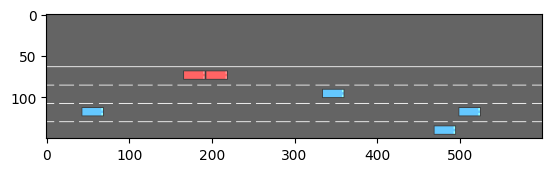

Episode length 6.638840516017888
Average over 5 runs : 17.781356655922202


In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
#replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
    
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)
    
class DQN_Skeleton: 
    def __init__(self,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                ): 
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        
        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min
        
        self.learning_rate = learning_rate
        
        self.reset()
        
    def get_action(self, state):
        """
        ** TO BE IMPLEMENTED LATER**

        Return action according to an epsilon-greedy exploration policy
        """
        pass
    
    def update(self, *data):
        """
        ** TO BE IMPLEMENTED LATER **

        Updates the buffer and the network(s)
        """
        pass
    
    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):
        hidden_size = 128
        
        obs_size = self.observation_space.shape[0]
        n_actions = self.action_space.n
        
        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)
        
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0
    
class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, *args):
        return self.action_space.sample()
    
    def update(self, *data):
        pass

class DQN_SkeletonI(DQN_Skeleton):   
    def get_action(self, state, epsilon=None):
        """
            ** Solution ** 
        
            Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None: 
            epsilon = self.epsilon
            
        if np.random.rand() < epsilon: 
            return env.action_space.sample()
        else: 
            return np.argmax(self.get_q(state))

def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


agent = RandomAgent(env.observation_space, env.action_space)

def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = display_env.step(action)
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'Episode length {rewards}')
    
run_one_episode(env, agent, display=True)
print(f'Average over 5 runs : {np.mean(eval_agent(agent, env))}')

In [4]:
class DQN(DQN_SkeletonI):   
    def update(self, state, action, reward, terminated, next_state):
        """
        ** SOLUTION **
        """

        # add data to replay buffer
        self.buffer.push(torch.tensor(state).unsqueeze(0), 
                           torch.tensor([[action]], dtype=torch.int64), 
                           torch.tensor([reward]), 
                           torch.tensor([terminated], dtype=torch.int64), 
                           torch.tensor(next_state).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        # Compute loss - TO BE IMPLEMENTED!
        # Hint: use the gather method from torch.

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        values  = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()
    



action_space = env.action_space
observation_space = env.observation_space

gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

arguments = (action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every, 
            epsilon_start, 
            decrease_epsilon_factor, 
            epsilon_min,
            learning_rate,
        )

N_episodes = 300

agent = DQN(*arguments)


def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done: 
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1)% eval_every == 0):
            rewards = eval_agent(agent, env)
            print("episode =", ep+1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break
                
    return losses

    
# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))

KeyError: 11